# MNIST

In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
#assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Scikit-Learn 可以載入的資料組通常有相似的目錄結構，包括：
- 描述資料組的 DESCR key
- 有一個陣列的 data key，陣列內每個實例（instance）為一列，每個特徵為一欄
- 一個 target key，裡面包含標籤的陣列

In [4]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print('--------')
print(y.shape)

(70000, 784)
--------
(70000,)


每個特徵代表一個像素的顏色深淺，從 0（白色）到 255（黑色）

In [5]:
28 * 28

784

In [6]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

In [7]:
type(X)

pandas.core.frame.DataFrame

In [8]:
X.loc[0]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64

In [9]:
X.iloc[0]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64

(-0.5, 27.5, 27.5, -0.5)

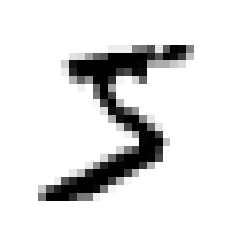

In [10]:
some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = 'binary') 
plt.axis('off')

#plt.show()

In [11]:
type(y)

pandas.core.series.Series

In [12]:
y[0]

'5'

In [13]:
type(y[0])

str

In [14]:
# 原先是字串，轉成整數數字
y = y.astype(np.uint8)

In [15]:
type(y[0])

numpy.uint8

In [16]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation = 'nearest')
    plt.axis('off')

In [17]:
# EXTRA
def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis = 1))
    image = np.concatenate(row_images, axis= 0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis('off')

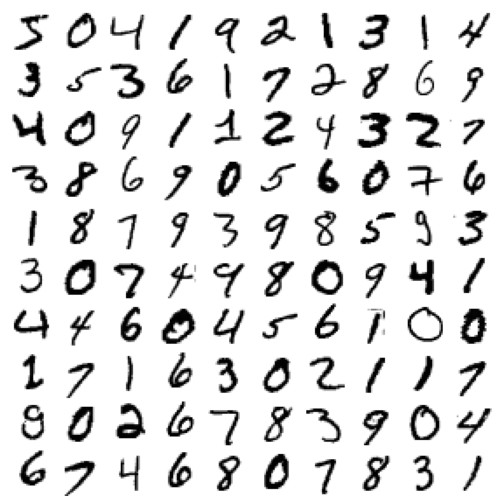

In [18]:
plt.figure(figsize = (9, 9))
example_images = np.array(X[:100])
plot_digits(example_images, images_per_row = 10)

plt.show()

In [19]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 訓練二元分類器

簡化問題，只嘗試辨識一個數字，5和非5。由於只能辨識兩個類別，因此是一個 Binary classifier

In [20]:
# 所有的 5 都是 True，所有其他的數字都是 False
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

建立一個隨機梯度下降（Stochastic Gradient Descent，SGD）分類器。此分類器的優點是，可以高效地處理非常大型的資料組，部分原因是 SGD 以獨立的方式處理訓練實例，每次處理一個（SGD 非常適合用在線上學習 online learning）

In [21]:
from sklearn.linear_model import SGDClassifier

In [22]:
sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

SGDClassifier 的訓練過程需要依靠隨機性，如想要重現結果，就要設定 random_state 參數

檢測數字 5 的圖片

In [23]:
sgd_clf.predict([some_digit])

array([ True])

# 評量績效

## 用交叉驗證評估準確度

K-fold 交叉驗證的意思是將訓練組拆分 K 個 fold，接著使用以其他 fold 訓練的模型，來對它們進行預測並評估

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

上面結果顯示都有超過 93% 的準確率，看似不錯，但可看一下下面的分類氣，將每一張圖片都分類為不是 5

In [26]:
from sklearn.base import BaseEstimator

In [27]:
class Never5Classifier(BaseEstimator): 
    def fit(self, X, y = None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [28]:
never_5_clf = Never5Classifier()

In [29]:
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

準確率也超過 90%，這是因為只有大約 10% 的圖片是 5，所以都猜圖片不是 5，90% 都會猜對。

這說明為何準確率通常不是評估分類器的首要指標，尤其當資料組有偏差(skew)時，即有些類別比其他類別更常出現

#### 實作交叉驗證

以下方式大致上與 Scikit-Learn 的 cross_val_score()相同，也會印出相同的結果

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [31]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)
skfolds.split(X_train, y_train_5)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


StratifiedKFold 類別執行分層抽樣來產生 fold，這些 fold 中有具代表性的類別比率

每次迭代時都會建一個分類器複製品，用訓練 fold 來訓練那些複製品，再用測試 fold 進行預測，接著計算正確的預測數量，並輸出正確預測比率

## 混淆矩陣

評估分類器最佳的工具是混淆矩陣（confusion matrix），概念大致是計算類別 A 的實例被分類到類別 B 的次數。這要利用預測值與實際值相互比較才會得到

In [33]:
from sklearn.model_selection import cross_val_predict

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [37]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

cross_val_predict() 與 cross_val_score() 一樣執行 K-fold 交叉驗證，傳回的不是評估分數，而是回傳對著各個測試 fold 進行的預測，也就是說可以得到模型對每一個訓練組實例進行的預測

可用 confiusion_matrix() 取得混淆矩陣

In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

混淆矩陣的每一列(row)都代表一個實際的類別，每一行(column)都代表一個預測的類別，完美的分類器只有 true positive 與 true negative，也就是混淆矩陣的主對角線（左上到右下）才會有非零的值

In [41]:
y_train_perfect_predictions = y_train_5  # 假設得到完美的結果
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

另外會看的指標是分類器的 precision（精度)，會搭配另一個評量指標，稱為 recall（或稱為 sensitivity 或 true positive 率(TPR)
）

$Precision$

$precision = \frac{TP}{TP + FP}$

TP is the number of true positives, and FP is the number of false positives


$Recall$

$recall = \frac{TP}{TP + FN}$

FN is, of course, the number of false negatives

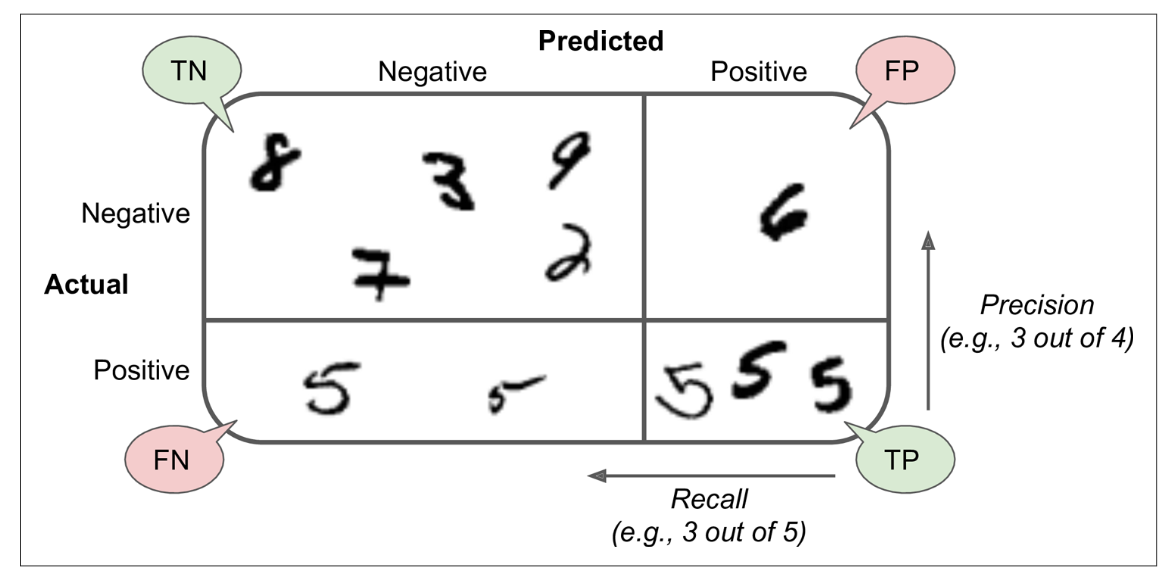

## precision 與 recall

In [62]:
from sklearn.metrics import precision_score, recall_score

In [43]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [45]:
3530 / (3530 + 687)

0.8370879772350012

In [44]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [46]:
3530 / (3530 + 1891)

0.6511713705958311

當需要簡單的比較兩個分類器時，可使用 F1 分數。F1 分數是 precision 與 recall 的調和平均數。通常在計算平均數時，會平等看待每一個值，但調和平均數賦予小值更高全重，因此，為有 recall 與 precision 的分數都很高時，分類器的 F1 分數才會高

$F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP+\frac{FN+FP}{2}}$

In [47]:
from sklearn.metrics import f1_score

In [49]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

當分類器具有相似的 precision 和 recall 時，F1 分數較高

但通常 precision 和 recall 會有個取捨，提升 precision 會降低 recall，反之亦然，This is called the precision/recall trade-off.

## precision / recall 取捨

SGDClassifier 使用決策函數來為每個實例計算一個分數，如果分數大於某個閥值，就會將實例指派給某一類別，否則就指派給另一類別

Scikit-Learn 可讀取用來進行預測的研判分數，呼叫分類器的 decision_function()，來取得各個實例的分數，再使用任何閥值，根據這些分數進行決策

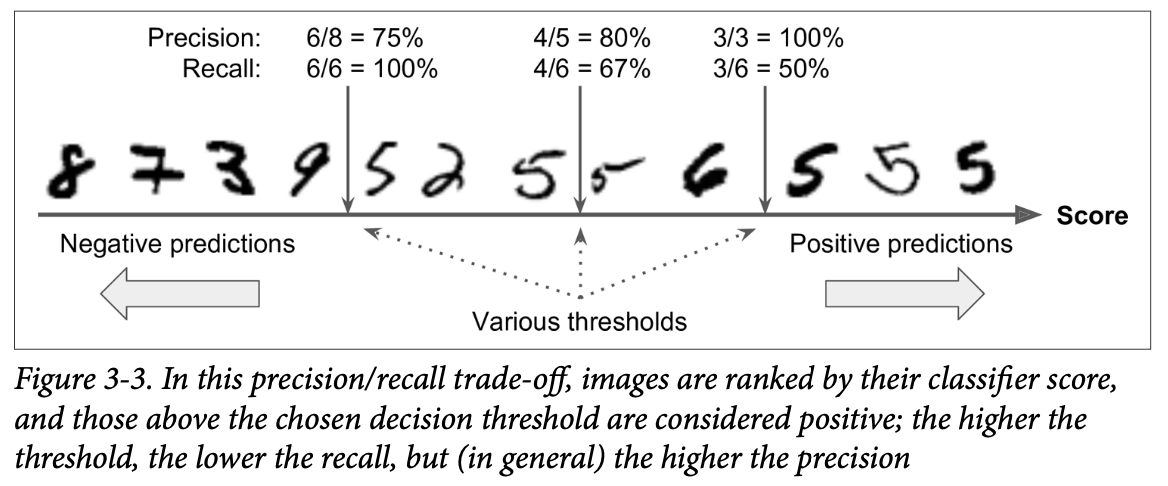

In [52]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [54]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [55]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

由上可以看出，提升 threshol 會降低 recall

如何決定閥值？可使用 cross_val_predict()來取得訓練組的所有實力的分數，但要指定得到 decision 分數，而非 prediction

In [56]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

得到分數後，使用 precision_recall_curve() 來計算所有可能的閥值的 precision 與 recall

In [57]:
from sklearn.metrics import precision_recall_curve

In [58]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

使用 matplotlib 將 precesion 與 recall 畫成閥值函數

In [59]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision', linewidth = 2)
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall', linewidth = 2)
    plt.legend(loc = 'center right', fontsize = 16) 
    plt.xlabel('Threshold', fontsize = 16) 
    plt.grid(True)    
    plt.axis([-50000, 50000, 0, 1])

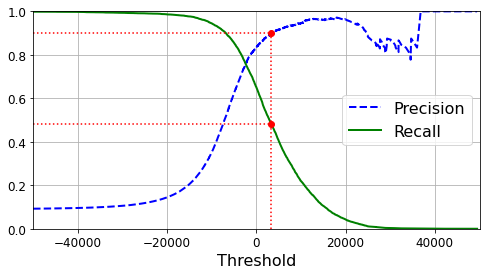

In [61]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize = (8, 4))                                              
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')   
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')       
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([threshold_90_precision], [0.9], 'ro')            
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')      

plt.show()

上圖的 precision 曲線不像 recall 曲線那麼平滑，主要是有時提高 threshold 時，precision 可能會下降（雖然通常它會上升）。而 recall 只會在 threshold 增加時下降

另一種方式時直接畫出 precesion vs. recall 的關係圖

In [63]:
(y_train_pred == (y_scores > 0)).all()

True

In [64]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth = 2)
    plt.xlabel('Recall', fontsize = 16)
    plt.ylabel('Precision', fontsize = 16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

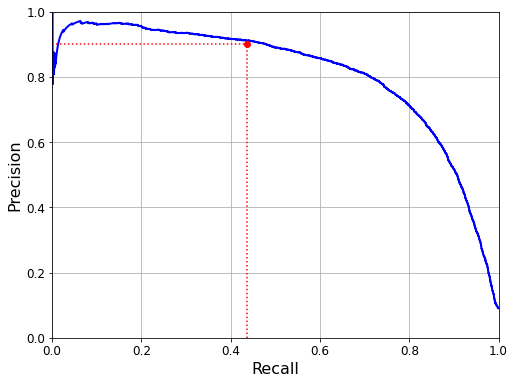

In [65]:
plt.figure(figsize = (8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], 'r:')
plt.plot([0.0, 0.4368], [0.9, 0.9], 'r:')
plt.plot([0.4368], [0.9], 'ro')

plt.show()

假設目標是 90% precision，為了得到更準確的閥值，可以搜尋提供至少 90% 的 precsion 的最低閥值，使用 np.argmax() 取得最大值的第一個索引

下面的例子中所代表的第一個 True 值

In [66]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [67]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [68]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [69]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

如果高 precision 的分類器有太低的 recall，這個就不太好用了～

所以當有人說有高達 99% 的 precision，就要問，這時的 recall 是多少？

## ROC 曲線  ROC Curve

ROC（receiver operating characteristic）curve 常和二元分類器一起使用，是畫出 true positive 率 (recall 的別名）vs. false positive 率（FPR)。FPR 是 negative 實例被錯誤地歸類為 positive 的比率，等於 1 減 true negative 率（TNR），TNR 是 negative 實例被正確地歸類為 negative 的比率，也稱為 specificity。因此，ROC 曲線畫的是 sensitivity（recall）vs. 1 - specificity

要畫 ROC 曲線，先使用 roc_curve() 來計算各個閥值的 TPR 與 FPR

In [70]:
from sklearn.metrics import roc_curve

In [71]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [72]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')      # dashed diagonal
    plt.axis([0, 1, 0, 1])      
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize = 16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize = 16)
    plt.grid(True)  

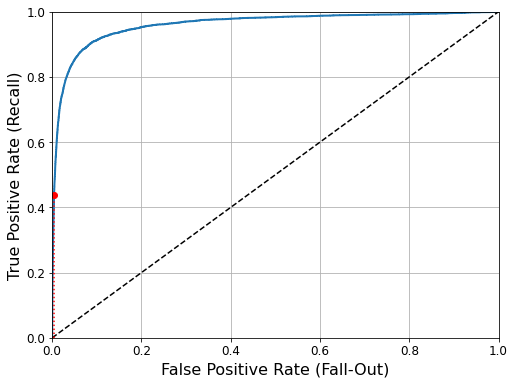

In [73]:
plt.figure(figsize = (8, 6)) 
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], 'r:') 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], 'r:') 
plt.plot([4.837e-3], [0.4368], 'ro')               

plt.show()

同樣也會面臨取捨，recall（TNR）越高，分類器產生的 false positive（FPR）越多。虛線是純隨機分類器的 ROC 曲線，離這條線越遠（靠左上角），分類器越好

另一種比較分類器的方法是計算曲線下方區域面積（area under the curve, AUC），完美的分類器的 ROC AUC 等於 1，純隨機分類器的 ROC AUC 等於 0.5

In [74]:
from sklearn.metrics import roc_auc_score

In [75]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

ROC 曲線非常類似 precision/recall(PR) 曲線，根據經驗，當陽性類別很少，或當比較在意 false positive 而非 false negative 時，應該優先選擇 PR 曲線，否則就使用 ROC 曲線

從上面的 ROC 曲線及 ROC AUC 分數，或許會覺得這個分類器很好，但有一很大程度是因為陽性類別(5)比陰性類別(非5)少很多，相較之下，PR 曲線可明顯地顯示該分類器還有改善的空間，即曲線還可以更靠近左上角

訓練一個 RandomForestClassifier，並拿 ROC 曲線和 ROC AUC 分數與 SGDClassifier 做比較

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

先要取得訓練組的各個實例的分數，但 RandomForestClassifier 沒有 decision_function()，但有 predict_proba()（Scikit-Learn 的分類器通常有這兩種方法中的一種，或是同時擁有兩個）。predict_proba() 回傳一個陣列，每個實例都有一列，每個類別都有一欄，內容是特定實例屬於特定類別的機率

In [86]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

roc_curve() 是輸入標籤和分數，但可以給它類別機率而非分數

In [78]:
y_scores_forest = y_probas_forest[:, 1]  # 分數 = 陽性類別的機率
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

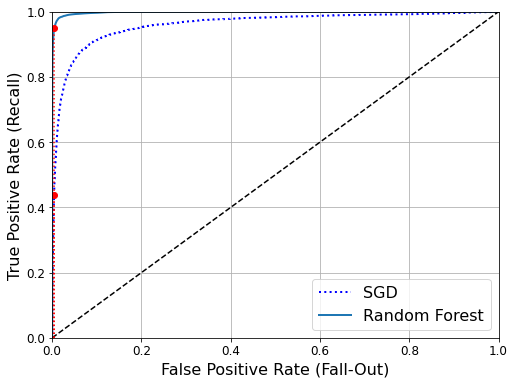

In [79]:
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, 'b:', linewidth = 2, label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], 'r:')
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], 'r:')
plt.plot([4.837e-3], [0.4368], 'ro')
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], 'r:')
plt.plot([4.837e-3], [0.9487], 'ro')
plt.grid(True)
plt.legend(loc = 'lower right', fontsize = 16)

plt.show()

由圖上可看出，隨機森林分類器優於 SGD 分類器，因為其 ROC 曲線靠近左上角許多，且有更大的 AUC

In [80]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

precision

In [81]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

recall

In [82]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# 多類別分類  Multiclass classification

多類別分類器（也稱為多項（multinomial）分類器）是可區分超過兩個類別

有些演算法（如 SGD 分類器、隨機森林分類器、樸素 Bayes 分類器）本身就可處理多個類別，其他分類器（如 Logistic 回歸、支援向量機分類器）都是二元分類器，但可透過方法使用多個二元分類器來達到執行多類別分類

如要分成 10 個類別，可訓練 10 個二院分類器，每一個負責一個類別，在分類時，讓各個分類器輸出該類別的判斷分數，看哪個分類器輸出最高的分數，就選擇該類別，此種做法稱為**一對其餘（one-versus-the-rest, OvR）**策略（也稱為*一對全部（one-versus-all）*）

另外一種是將每一對類別訓練一個二元分類器，如一個負責區分類別一和類別二，另外一個區分類別一和類別三，以此類推，這種做法稱為**一對一（OvO）**策略，如果類別有 N 個，就要訓練 N x (N - 1) / 2 個分類器。OvO 的主要優點是訓練各個分類器時，只要用它區分的兩個類別來訓練即可

有些演算法（如支援向量幾）無法隨著訓練組規模的增加而很好地擴展，對這些演算法，OvO是首選，因為用小型的訓練組來訓練許多分類器的速度，比用大型的訓練組來訓練少量的分類器快得多，但對多數的二元分類器演算法而言，OvR 是首選

Scikit-Learn 偵測所使用二元分類器演算法來處理多類別分類任務，並根據演算法自動執行 OvR 或 OvO

In [87]:
from sklearn.svm import SVC

In [88]:
svm_clf = SVC(gamma = 'auto', random_state = 42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

上面 Scikit-Learn 是使用 OvO 策略，訓練了 45 個二元分類器，取得對類別的研判分數，在選擇互相競爭中勝出的類別

使用 decision_function() 會看到它為每個實例回傳 10 個分數（而非 1 個），每個類別都有一個分數

In [89]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

查看最高分

In [90]:
np.argmax(some_digit_scores)

5

In [91]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [92]:
svm_clf.classes_[5]

5

當分類器訓練好後，會將目標類別串列存入其 classes_ 類別，按值排序

要強迫 Scikiti-Learn 使用一對一或一對其餘，可使用 OneVsOneClassifier 或 OneVsRestClassifier

In [93]:
from sklearn.multiclass import OneVsRestClassifier

In [94]:
ovr_clf = OneVsRestClassifier(SVC(gamma = 'auto', random_state = 42))
# ovr_clf.fit(X_train, y_train)
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [95]:
len(ovr_clf.estimators_)

10

訓練 SGDClassifier

Scikit-Learn 不需執行 OvR 或 OvO，因為 SGD 分類器可直接將實例分成多個類別，decision_function() 為每個類別回傳一個值

In [96]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [97]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

使用交叉驗證，用 cross_val_score() 來評估 SGDClassifier 的準確率

In [98]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

使用縮放輸入尺度就可以使準確率再提高

In [101]:
from sklearn.preprocessing import StandardScaler

In [103]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [105]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

# 誤差分析  Error Analysis

當嘗試過多個模型，且選出最有希望的，並以使用 GridSearchCV 微調過超參數，就盡可能的自動化。而可利用分析該模型所產生的誤差之類別來找到改善的方法

繪製混淆矩陣

In [106]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)

In [107]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

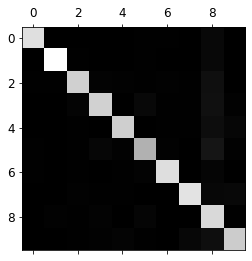

In [108]:
plt.matshow(conf_mx, cmap = plt.cm.gray)

plt.show()

繪製誤差圖

先將混淆矩陣的每一個值除以對應類別的數量，來比較錯誤率，而不是使用絕對錯誤數量，這會使得數量豐富的類別看起來很糟

In [111]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

將對角線填上零，只保留錯誤率，並繪製出來

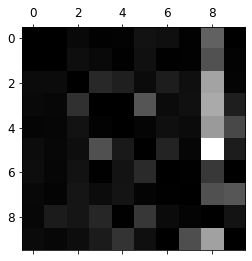

In [112]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

plt.show()

可看到分類器所犯下的錯誤類別。列代表真正的類別，行代表預測的類別，從欄看很亮的地方表示很多被錯誤地被分類到該類別上

透過分析混淆矩陣可以找出改善分類的的方法，若發現某一類別很常被錯誤分類到，可是著多收集該類別的訓練資料，讓分類器學習可區分出來，也可設計新特徵來協助分類器，如預處理輸入資料等

分析個別的錯誤也可了解分類器問題的地方，但此方法較困難且花時間

In [ ]:
# EXTRA
def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis = 1))
    image = np.concatenate(row_images, axis= 0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis('off')

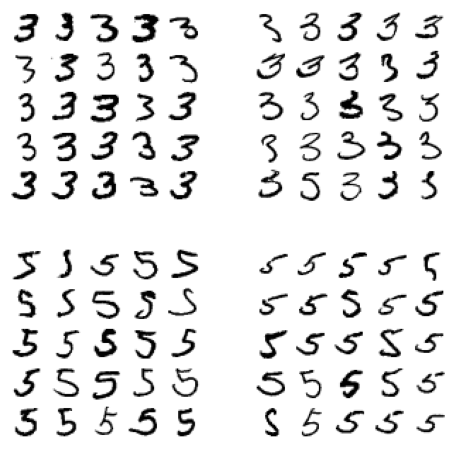

In [120]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8, 8))
plt.subplot(221); plot_digits(np.array(X_aa[:25]), images_per_row = 5)
plt.subplot(222); plot_digits(np.array(X_ab[:25]), images_per_row=5)
plt.subplot(223); plot_digits(np.array(X_ba[:25]), images_per_row=5)
plt.subplot(224); plot_digits(np.array(X_bb[:25]), images_per_row=5)

plt.show()

上圖中左邊兩個 5X5 區塊是被歸類為 3 的圖片，右邊則是被歸類為 5 的圖片。可以檢視內容，因為使用 SGDClassifier，這是一個線性模型，做法是幫每一個像素設定各個類別的權重，當看到新圖片時，只是把加權的像素強度總和起來，得到每個類別的分數，所以因為 3 和 5 的差異只是在幾個像素，因此模型很容易分不清。可透過預先處理圖片來確保都能正確被分類

# 多標籤分類  Multilabel Classification

分類器為各個實例輸出多個類別，這種可輸出多個二元標籤的分類系統稱為**多標籤分類系統**

In [121]:
from sklearn.neighbors import KNeighborsClassifier

In [122]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

建立一個 y_multilabel 趁列，有各個數位圖像的目標標籤：是不是大數字（7, 8, 9），是不是奇數

In [123]:
knn_clf = KNeighborsClassifier()  # KNN 支援多標籤分類
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [137]:
some_digit

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [124]:
knn_clf.predict([some_digit])   # some_digit 為 5

array([[False,  True]])

結果就輸出兩個標籤，數字 5 不大（false），是為奇數（True）

評估多標籤分類器方法很多，正確的評量標準是任務而定

可謂各個單獨的標籤評量 F1 分數，接著直接計算平均分數

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

計算所有標籤的平均 F1 分數

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

以上是所有標籤的重要性一樣時使用，但如果有標籤的數量多，可能會讓該標籤的分類器分數有更多權重，一種簡單的方法是讓每一個標籤的權重等於它的 *suppor*（也就是該標籤的實例數量）

只要在 average 參數上設定等於 weighted

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average = 'weighted')

# 多輸出分類  Multioutput Classification

多輸出多類別分類（簡稱**多輸出分類**），是更廣泛的多標籤分類，各個標籤都可有多個類別（也就是它的值可超過兩個）

建立一個移除圖像雜訊的系統，接收有雜訊的圖像，並輸出一張乾淨的圖像

分類器的輸出是多標籤的（每個像素一個標籤），且各個標籤可以是多個值（像素強度的範圍是 0 到 255 ），因此是個多輸出分類系統

In [140]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

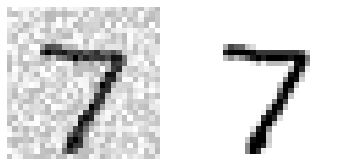

In [141]:
some_index = 0
plt.subplot(121); plot_digit(np.array(X_test_mod.iloc[some_index]))
plt.subplot(122); plot_digit(np.array(y_test_mod.iloc[some_index]))

plt.show()

In [142]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])

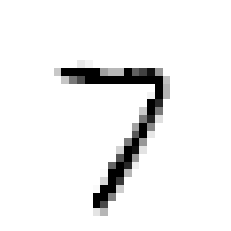

In [143]:
plot_digit(clean_digit)

# Extra material

## Dummy (ie. random) classifier

In [144]:
from sklearn.dummy import DummyClassifier

In [145]:
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')
y_probas_dmy

array([[0.90965, 0.09035],
       [0.90965, 0.09035],
       [0.90965, 0.09035],
       ...,
       [0.90965, 0.09035],
       [0.90965, 0.09035],
       [0.90965, 0.09035]])

In [146]:
y_scores_dmy = y_probas_dmy[:, 1]
y_scores_dmy

array([0.09035, 0.09035, 0.09035, ..., 0.09035, 0.09035, 0.09035])

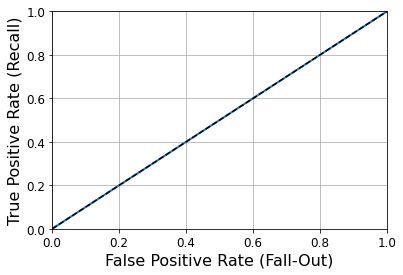

In [147]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [148]:
from sklearn.neighbors import KNeighborsClassifier

In [149]:
knn_clf = KNeighborsClassifier(weights = 'distance', n_neighbors = 4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [150]:
y_knn_pred = knn_clf.predict(X_test)

In [151]:
from sklearn.metrics import accuracy_score

In [152]:
accuracy_score(y_test, y_knn_pred)

0.9714

In [153]:
from scipy.ndimage.interpolation import shift

In [154]:
def shift_digit(digit_array, dx, dy, new = 0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval = new).reshape(784)

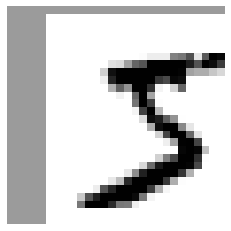

In [155]:
plot_digit(shift_digit(some_digit, 5, 1, new = 100))

In [156]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis = 1, arr = X_train, dx = dx, dy = dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [157]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [158]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [159]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [161]:
ambiguous_digit = X_test.iloc[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

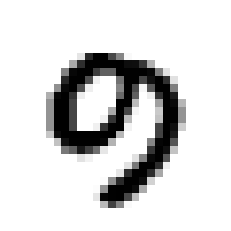

In [163]:
plot_digit(np.array(ambiguous_digit))